## Important files / commands

~/readout/host/ali_offline_demod.py -> contains demoding functions; used anytime you see "dm." in the scripts below

~/readout/host/ali_iv_analysis_2.py -> contains repaired functions for IV analysis; used anytime you see "iv." (not in this notebook as I left it, but in many other places)

~/readout/host/semi_live_demod_2.py -> the live monitor we were looking at; you'll want to run this in a terminal; it automatically starts live demoding the most recent time stream file, so you'll want to get continuous datataking up and running first; it knows how to find the correct channel standard

~/readout/host/channel_standards/\*.csv -> contains the master list of channels; use the right-most column to turn channels on and off in the live demod; you can ignore the .ods versions

ssh xilinx@192.168.2.99 -> log onto rfsoc

On rfosc: cd rfsoc2 -> directory from which to run sudo python3 redisControl.py when using the external flux ramp

~/readout1_before_fr_upgrade/host/kidpy_bias.py -> version of kidpy to use with external flux ramp; for running the readout

## Packages: run these first

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/home/matt/readout/host/')
import ali_offline_demod as dm
import ali_iv_analysis_2 as iv
import imp
import glob
import pickle
from scipy import spatial
import h5py
from scipy.fft import fft, ifft, fftfreq
from copy import deepcopy
from scipy.interpolate import CubicSpline, interp1d
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm
import imp
import pandas as pd
from scipy.signal import savgol_filter as sg

/tmp/ipykernel_4727/3152699253.py:7: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


## Functions: run these at the beginning as well

Note that the three little dots means that the cell below has been collapsed to make it easier to view the notebook. Since the cell below contains some functions needed for analysis, expand it and run it. You can collapse it again by clicking the colored bar to the left of the cell.

In [2]:
#older demod code

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def extract_phase(t, data, n, n_blank, intermediate_plotting_limits = [None, None], plot_fft = False, plot_limited_fft = False, plot_fit = False, plot_vectors = False, plot_phase = False, verbose = False):
    """
    params
    ======
    data: data from a single flux ramp reset period
    n: number of harmonics preserved
    n_blank: number of points cut from end (to help remove flux ramp reset period)
    plot_fft: If true, plot the relevant ffts (default = False)
    plot_fit: If true, plot the relevant fit (default = False)
    """      
    #find the the two fft terms with the most power
    if intermediate_plotting_limits[0] == None:
        intermediate_plotting_limits[0] = t[0]
    if intermediate_plotting_limits[1] == None:
        intermediate_plotting_limits[1] = t[-1]
    
    data_fft = fft(data)
    freqs = fftfreq(len(data), np.median(np.diff(t)))
    
    if plot_fft == True and t[0] >= intermediate_plotting_limits[0] and t[0] <= intermediate_plotting_limits[1]:
        fig1, ax1 = plt.subplots(1)
        
        ax1.stem(freqs, np.abs(data_fft))
        ax1.set_xlabel('Frequency (Hz)')
        ax1.set_ylabel('Amplitude (arb.)')
        ax1.set_xlim([-500,500])
        ax1.set_title(f'$t_0$ = {t[0]} s')
        
    #blank the dc term
    no_dc_fft = deepcopy(data_fft)
    np.put(no_dc_fft, [0], 0.0)
    
    fundamental_idx_1 = np.argmax(np.abs(no_dc_fft))
    #print(fundamental_idx_1)
    remove_highest = deepcopy(no_dc_fft)
    #print(len(remove_highest))
    np.put(remove_highest, [fundamental_idx_1, int(len(remove_highest)-fundamental_idx_1)], 0.0) #remove the highest term and its complex conjugate in order to search for the second highest term
    fundamental_idx_2 = np.argmax(np.abs(remove_highest))
    #print(fundamental_idx_2)
    
    mask = np.zeros(len(data))
    try:
        for i in range(n):
            np.put(mask, [fundamental_idx_1*(i+1), fundamental_idx_2*(i+1)], 1.0)
            np.put(mask, [len(data)-(fundamental_idx_1*(i+1)), len(data)-(fundamental_idx_2*(i+1))], 1.0)
    except IndexError:
        print('Harmonic setting (n) too high. Using highest harmonic available.')
        
    data_fft_harmonics_only = data_fft * mask
    
    fit = ifft(data_fft_harmonics_only)
    
    if fundamental_idx_1 >= fundamental_idx_2:
        #print('1>=2')
        R1 = np.real(data_fft_harmonics_only[fundamental_idx_1])
        R2 = np.real(data_fft_harmonics_only[fundamental_idx_2])

        I1 = np.imag(data_fft_harmonics_only[fundamental_idx_1])
        I2 = np.imag(data_fft_harmonics_only[fundamental_idx_2])
        
    elif fundamental_idx_1 < fundamental_idx_2:
        #print('1<2')
        R1 = np.real(data_fft_harmonics_only[fundamental_idx_2])
        R2 = np.real(data_fft_harmonics_only[fundamental_idx_1])

        I1 = np.imag(data_fft_harmonics_only[fundamental_idx_2])
        I2 = np.imag(data_fft_harmonics_only[fundamental_idx_1])
        
    
    if I1 > 0:
        angle1 = np.angle(R1+1j*I1)
    elif I1 < 0:
        angle1 = 2*np.pi + np.angle(R1+1j*I1)
    elif I1 == 0 and R1 > 0:
        angle1 = 0
    elif I1 == 0 and R1 < 0:
        angle1 = np.pi
        
    if I2 > 0:
        angle2 = np.angle(R2+1j*I2)
    elif I2 < 0:
        angle2 = 2*np.pi + np.angle(R2+1j*I2)
    elif I2 == 0 and R2 > 0:
        angle2 = 0
    elif I2 == 0 and R2 < 0:
        angle2 = np.pi
        
    if R2 > 0 and I2 > 0 and R1 > 0 and I1 < 0: #unusual situation where vec2 is in Q1 and vec1 is in Q4: need to rotate vec2 CW (formula 2)
        interpolated_phase1 = np.arctan2((I1-R2),(R1+I2))
        formula = 2
    elif angle1 > angle2:
        interpolated_phase1 = np.arctan2((I1+R2),(R1-I2))
        formula = 1
    elif angle2 > angle1:
        interpolated_phase1 = np.arctan2((I1-R2),(R1+I2)) #something is wrong with this formula; the vector plots don't look right
        formula = 2
    
    
    #interpolated_phase1 = np.angle(data_fft_harmonics_only[fundamental_idx_1])
    #interpolated_phase2 = np.angle(data_fft_harmonics_only[fundamental_idx_2])
    #interpolated_phase1 = np.arctan2((I1+R2),(R1-I2))
    interpolated_phase2 = np.arctan2(I2,R2)
    #interpolated_phase2 = (np.arctan(I1/R1) + np.arctan(I2/R2)-np.pi/2)/2
    
    t_phase = np.median(t)
    
    
    
    if plot_limited_fft == True and t[0] >= intermediate_plotting_limits[0] and t[0] <= intermediate_plotting_limits[1]:
        fig2, ax2 = plt.subplots(1)
        
        ax2.stem(freqs, np.abs(data_fft_harmonics_only))
        ax2.set_xlabel('Frequency (Hz)')
        ax2.set_ylabel('Amplitude (arb.)')
        ax2.set_xlim([-500,500])
    
    if plot_fit == True and t[0] >= intermediate_plotting_limits[0] and t[0] <= intermediate_plotting_limits[1]:
        fig3, ax3 = plt.subplots(1)
        
        ax3.plot(t, data, '.',label='Data')
        ax3.plot(t, fit, label='fit')
        ax3.set_xlabel('t (s)')
        ax3.set_ylabel('Amplitude (arb.)')
        
    if plot_vectors == True and t[0] >= intermediate_plotting_limits[0] and t[0] <= intermediate_plotting_limits[1]:
        fig4, ax4 = plt.subplots(1)
        
        vec1 = [0+0j, data_fft_harmonics_only[fundamental_idx_1]]
        vec2 = [0+0j, data_fft_harmonics_only[fundamental_idx_2]]
        if R2 > 0 and I2 > 0 and R1 > 0 and I1 < 0: #unusual situation where vec2 is in Q1 and vec1 is in Q4: need to rotate vec2 CW (formula 2)
            vec3 = [0+0j, (R1+I2)+1j*(I1-R2)]
            label = 'angle2 > angle1; ususual Q4/Q1 case'
        elif angle1 > angle2:
            vec3 = [0+0j, (R1-I2)+1j*(R2+I1)]
            label = 'angle1 > angle2'
        elif angle2 > angle1:
            vec3 = [0+0j, (R1+I2)+1j*(I1-R2)]
            label = 'angle2 > angle1'
        
        ax4.plot(np.real(vec1), np.imag(vec1),label='vec1')
        ax4.plot(np.real(vec2), np.imag(vec2),label='vec2')
        ax4.plot(np.real(vec3), np.imag(vec3),label=label)
    
        ax4.set_xlabel('Re')
        ax4.set_ylabel('Im')
        ax4.set_xlim([-1000,1000])
        ax4.set_ylim([-1000,1000])
        ax4.legend()
    
    if plot_phase == True and t[0] >= intermediate_plotting_limits[0] and t[0] <= intermediate_plotting_limits[1]:
        fig5, ax5 = plt.subplots(1)
        
        data_fft_phase_threshold = deepcopy(data_fft_harmonics_only)
        threshold = max(np.abs(data_fft_phase_threshold))/10000
        data_fft_phase_threshold[np.abs(data_fft_phase_threshold) < threshold] = 0.0
        
        ax5.stem(freqs,np.angle(data_fft_phase_threshold))
        
    if verbose == True:
        print(f'Angle 1: {angle1} Angle 2: {angle2} Formula: {formula}')
        
    
    return freqs, data_fft_harmonics_only, t, fit, t_phase, interpolated_phase1, interpolated_phase2

def demodulate(t,sig,channels,chunks,n_zeroed,f_fr,time_method='original',phase_units='rad',correct_accumulated_phase=False,use_sg_filter=False,sg_degree=3,plot_demod = False,plot_demod_title=None,intermediate_plotting_limits=[None,None],plot_chunking_process = False,plot_fft = False,plot_limited_fft = False,plot_fit = False,plot_vectors = False,plot_phase = False,save_individual=False,save_path='/home/matt/Documents',save_note='demod_plot',verbose = False):
    """
    time_method: if 'original' chunking maintains true time, if 'zeroed' chuning zeros each chunk
    """
    
    if plot_demod == True:
        fig_demod, ax_demod = plt.subplots(1)
    
    count=0
    for ch in tqdm(channels):
        #establish array for storing phase
        phase_array = np.array([])
        
        if plot_chunking_process == True:
            #print(sig[ch])
            fig1, ax1 = plt.subplots(1)
            ax1.plot(t,sig[ch],'.-')

        #interpolate the data
        interpolation = interp1d(test_ts_processed['fr t'], test_ts_processed['fr data'][ch])

        t_final = t[-1]
        t_start = t[0]
        t_elapsed = t_final - t_start
        n_reset_periods = t_elapsed * f_fr

        t_interp = np.linspace(t_start, t_final, int(n_reset_periods)*1024)
        sig_interp = interpolation(t_interp)
        
        if plot_chunking_process == True:
            fig2, ax2 = plt.subplots(1)
            ax2.plot(t_interp, sig_interp,'.')

            
            fig3, ax3 = plt.subplots(1)
            fig4, ax4 = plt.subplots(1)    
            fig5, ax5 = plt.subplots(1)

        chunk_start_idx = find_nearest_idx(t_interp, test_ts_processed['fr t'][test_ts_processed['start index']])
        n_fr = f_fr*(t_interp[-1] - t_interp[chunk_start_idx])
        n_ptsfr = len(t_interp[chunk_start_idx:]) / n_fr

        chunk_count = 0
        for chunk in chunks:          
            
            #chunk the interpolated data
            channel_start_idx = find_nearest_idx(t_interp, t[test_ts_processed['start index']]) #+10
            #chunk_stop_idx = find_nearest_idx(t_interp, t[test_ts_processed['reset indices'][chunk+1]])

            idx_increase = round(n_ptsfr)

            start = channel_start_idx + idx_increase*chunk
            stop = channel_start_idx + idx_increase*(chunk + 1)
            
            average = np.average(sig_interp)
            
            t_chunk = t_interp[start:stop] 
            if time_method == 'zeroed':
                t_chunk -= t_interp[start]

            sig_chunk = sig_interp[start:stop]-average
            #print(f'len t_chunk: {len(t_chunk)}')
            

            if plot_chunking_process == True:
                ax3.plot(t_chunk, sig_chunk,'.',alpha = 0.5)

            #set points that are part of fr reset period to zero        
            endpoint_idx = find_nearest_idx(t_chunk,t[test_ts_processed['reset indices'][chunk+1]-n_zeroed]+t[test_ts_processed['start index']]) #figure out the time stamp in the interpolation that is closest to the blanking point in the original data
            #n_points_no_interp = (t[-1]-t[0])*f_fr
            #idx_increase_no_interp = int(n_points_no_interp)
            #print(f'len t_chunk: {len(t_chunk)}')
            #print(f'endpoint idx no interp: {t[test_ts_processed["start index"]] + idx_increase_no_interp*(chunk+1) - n_zeroed}')
            #endpoint_idx = find_nearest_idx(t_chunk,t[test_ts_processed['start index']] + idx_increase_no_interp*(chunk+1) - n_zeroed)
            #print(f'endpoint idx: {endpoint_idx}')
            sig_chunk[endpoint_idx:] = 0

            if plot_chunking_process == True:
                ax4.plot(t_chunk, sig_chunk, '.')

            sig_zero_pad = np.append(sig_chunk, np.zeros(len(sig_chunk)))
            diff = np.median(np.diff(t_chunk))
            t_zero_pad = np.append(t_chunk, np.linspace(t_chunk[-1]+diff, (t_chunk[-1]+diff) + (t_chunk[-1] - t_chunk[0]), len(t_chunk)))
            #np.linspace(t_chunk[0], t_chunk[-1] + (t_chunk[-1] - t_chunk[0]), 2*len(t_chunk))

            if plot_chunking_process == True:
                ax5.plot(t_zero_pad, sig_zero_pad, '.',alpha=0.5)




            
            freqs, data_fft_harmonics_only, t_fit, fit, t_phase, phase1, phase2 = extract_phase(t=t_zero_pad, 
                                                                                                data=sig_zero_pad, 
                                                                                                n=1, 
                                                                                                n_blank=0, 
                                                                                                intermediate_plotting_limits = intermediate_plotting_limits,
                                                                                                plot_fft = plot_fft, 
                                                                                                plot_limited_fft = plot_limited_fft,
                                                                                                plot_fit = plot_fit,
                                                                                                plot_vectors = plot_vectors,
                                                                                                plot_phase = plot_phase,
                                                                                                verbose = verbose)

            phase_array = np.append(phase_array, phase1)
        phase_array = np.unwrap(phase_array)
        if phase_units == 'nPhi0':
            phase_array /= (2*np.pi) #convert to nPhi0
        elif phase_units == 'deg':
            phase_array /= 180/np.pi
        elif phase_units == 'rad':
            pass


        
        
        
        t_array = np.linspace(t[0], t[-1], len(chunks))
        #print(len(t_array))
        
        

        

        

        if correct_accumulated_phase == True:
            
            phase_array_diff = np.diff(phase_array)
            
            #fig_hist, ax_hist = plt.subplots(1)
            
            #ax_hist.hist(phase_array_diff)
            #print(phase_array_diff)
            
            #index where diff > threshold (make 1 for right now)
            
            threshold = 0.3
            discontinuity_index = np.argwhere(phase_array_diff > threshold)
            discontinuity_index = discontinuity_index.reshape(1,len(discontinuity_index))[0]
            #if len(discontinuity_index != 0):
            #    discontinuity_index = discontinuity_index
            #print(discontinuity_index)
            
              
            def linear_model(x,m,b):
                return m*x+b
            
            if len(discontinuity_index) != 0:
                
                print(f'need to stitch, ch: {ch}, chunk: {chunk}')
            
                phase_split = np.split(phase_array, discontinuity_index+1)
                t_split = np.split(t_array, discontinuity_index+1)

                #fig_sec_test, ax_sec_test = plt.subplots(1)
                phase_split_corrected = np.array([])
                t_split_corrected = np.array([])
                for i in range(len(phase_split)):
                    #print(f't split before: {len(t_split[i])}')
                    if len(phase_split[i]) >= 4:
                        #t_drop_final = np.delete(t_split[i],[0,len(t_split[i])-1])
                        #phase_drop_final = np.delete(phase_split[i],[0,len(phase_split[i])-1])

                        t_drop_final = t_split[i]
                        phase_drop_final = phase_split[i]
                    
                        #ax_sec_test.plot(t_drop_final, phase_drop_final,'.-')
                        #ax_sec_test.plot(t_split[i],phase_split[i],'.-')

                        linear_fit = curve_fit(linear_model, t_drop_final, phase_drop_final)

                        fitted_line = linear_model(t_drop_final,linear_fit[0][0],linear_fit[0][1])

                        phase_remove_accumulation = phase_drop_final - fitted_line
                        
                    else:
                        t_drop_final = t_split[i]
                        phase_drop_final = phase_split[i]
                        phase_remove_accumulation = phase_split[i]
                        #print(f'special t len: {len(t_drop_final)}')
                    
                    #print(f't split after: {len(t_split[i])}')
                    #print(f't_drop_final: {len(t_drop_final)}')
                    
                    if use_sg_filter == True:
                        sg_filter = sg(phase_remove_accumulation,len(phase_remove_accumulation),sg_degree)
                        
                        #ax_sec_test.plot(t_drop_final,phase_remove_accumulation)
                        #ax_sec_test.plot(t_drop_final,sg_filter)
                        
                        corrected_segment = phase_remove_accumulation - sg_filter
                    
                    else:
                        
                        corrected_segment = phase_remove_accumulation
                        
                        

                    phase_split_corrected = np.append(phase_split_corrected, corrected_segment)
                    t_split_corrected = np.append(t_split_corrected, t_drop_final)

                    #ax_sec_test.plot(t_drop_final,phase_drop_final,'.-')
                    #if len(phase_split[i]) >= 4:
                    #    ax_sec_test.plot(t_drop_final,fitted_line,'-')
                    
                    #ax_sec_test.plot(t_drop_final,corrected_segment,'.-')

                phase_array = phase_split_corrected
                t_array = t_split_corrected
                #print(len(t_array))
                #ax_sec_test.plot(t_array, phase_array)
            
            """
            if len(discontinuity_index) != 0:
                
                #np.append(0,discontinuity_index) #make first
                   
                for i in discontinuity_index:
                    print(i)
                    if i == discontinuity_index[0]:
                        phase_section = phase_array[0:i]
                        t_section = t_array[0:i]
                    elif i == discontinity_index[-1]:
                        phase_section = phase_array[i:]
                        t_section = t_array[i:]
                    else:
                        phase_section = phase_array[i:i+1]
                        t_section = t_array[i:i+1]
                    
                    fig_sec_test, ax_sec_test = plt.subplots(1)
                    ax_sec_test.plot(t_array,phase_array,'.-')
                    #linear_fit = curve_fit(lienar_model, t_array
            """          
            
            
            if len(discontinuity_index) == 0:
                #print('basic triggered')
                #linear_fit = curve_fit(linear_model, t_array, np.unwrap(phase_array))
                linear_fit = curve_fit(linear_model, t_array, phase_array)

                fitted_line = linear_model(t_array,linear_fit[0][0],linear_fit[0][1])

                phase_array -= fitted_line
                
                if use_sg_filter == True:
                    sg_filter = sg(phase_array,len(phase_array),sg_degree)
                    
                    phase_array -= sg_filter
                    
            
            
            
        if plot_demod == True:
            ax_demod.plot(t_array,phase_array+0.1*count,'-')
            ax_demod.set_ylim([0,1])
            if plot_demod_title != None:
                ax_demod.set_title(plot_demod_title)
            if phase_units == 'nPhi0':
                ax_demod.set_ylabel('Phase w/ Offset ($n_{\\Phi_0}$)')
            elif phase_units == 'deg':
                ax_demod.set_ylabel('Phase w/ Offset (deg.)')
            elif phase_units == 'rad':
                ax_demod.set_ylabel('Phase w/ Offset (rad.)')
            #ax_demod.plot(t_array[discontinuity_index],phase_array[discontinuity_index],'.',color='orange')
            #ax_demod.set_ylim([-0.2,0.2])
        
        if save_individual == True:
            fig_save, ax_save = plt.subplots(1)
            
            ax_save.plot(t_array,phase_array,'-')
            ax_save.set_xlabel('$t$ (s)')
            if phase_units == 'nPhi0':
                ax_save.set_ylabel('Phase ($n_{\\Phi_0}$)')
            elif phase_units == 'deg':
                ax_save.set_ylabel('Phase (deg.)')
            elif phase_units == 'rad':
                ax_save.set_ylabel('Phase (rad.)')
            ax_save.set_title(f'{save_note}_ch{ch}.png')
            
            fig_save.savefig(f'{save_path}/{save_note}_ch{ch}.png',dpi=500,bbox_inches='tight')
        
        count += 1
                
    return t_array, phase_array

def process_polarization_data(t_array, phase_array, f_sample, plot_polarization = False, intermediate_plotting_limits = [None, None], plot_input = False, plot_chunking_process = False, plot_fft = False, plot_fft_fit = False, plot_limited_fft = False, plot_limited_fft_fit = False, plot_vectors = False):
    
    if intermediate_plotting_limits[0] == None:
        intermediate_plotting_limits[0] = t_array[0]
    if intermediate_plotting_limits[1] == None:
        intermediate_plotting_limits[1] = t_array[-1]
    
    if plot_input == True:
        fig1, ax1 = plt.subplots(1)

        ax1.plot(t_array,phase_array,'.-')
        ax1.set_ylim([-0.1,0.1])

    n_sample = f_sample*(t_array[-1]-t_array[0])# - t_interp[chunk_start_idx])
    print(n_sample)
    n_pts_sample = len(t_array) / n_sample

    print(n_pts_sample)

    idx_increase = round(n_pts_sample)

    chunks = range(int(n_sample))

    if plot_chunking_process == True:
        fig2, ax2 = plt.subplots(1)
        fig3, ax3 = plt.subplots(1)

    amplitude_array = np.array([])
    t_sampled = np.array([])
    for chunk in chunks:

        start = idx_increase*chunk
        stop = idx_increase*(chunk + 1)

        #print(start,stop)



        t_chunk = t_array[start:stop]
        phase_chunk = phase_array[start:stop]

        average = np.average(phase_chunk)

        phase_chunk -= average
        
        if plot_chunking_process == True:
            ax2.plot(t_chunk,phase_chunk)
            ax2.set_ylim([-0.1,0.1])

        diff = np.median(np.diff(t_chunk))
        t_zero_pad = np.append(t_chunk, np.linspace(t_chunk[-1]+diff, (t_chunk[-1]+diff) + (t_chunk[-1] - t_chunk[0]), len(t_chunk)))
        phase_zero_pad = np.append(phase_chunk, np.zeros(len(phase_chunk)))

        if plot_chunking_process == True:
            ax3.plot(t_zero_pad, phase_zero_pad)
            ax3.set_ylim([-0.1,0.1])

        fft_power = fft(phase_zero_pad)
        fft_freq = fftfreq(len(phase_zero_pad), np.median(np.diff(t_zero_pad)))
        
        if plot_fft == True and t_array[0] >= intermediate_plotting_limits[0] and t_array[0] <= intermediate_plotting_limits[1]:
            fig4, ax4 = plt.subplots(1)
            ax4.stem(fft_freq, np.abs(fft_power))

        fft_fit = ifft(fft_power)
        
        if plot_fft_fit == True and t_array[0] >= intermediate_plotting_limits[0] and t_array[0] <= intermediate_plotting_limits[1]:
            fig5, ax5 = plt.subplots(1)
            ax5.plot(t_zero_pad, phase_zero_pad,'.')
            ax5.plot(t_zero_pad, fft_fit,'-')

        fft_remove_dc = deepcopy(fft_power)
        fft_remove_dc[0] = 0

        fundamental_idx = np.argmax(np.abs(fft_remove_dc))
        
        #print(f'fundamental_idx: {fundamental_idx}')


        mask = np.zeros(len(fft_remove_dc))
        n=1
        try:
            for i in range(n):
                np.put(mask, [0, fundamental_idx*(i+1), len(fft_remove_dc)-(fundamental_idx*(i+1))], 1.0)
        except IndexError:
            print('Harmonic setting (n) too high. Using highest harmonic available.')

        fft_masked = fft_remove_dc*mask
        
        if plot_limited_fft == True and t_array[0] >= intermediate_plotting_limits[0] and t_array[0] <= intermediate_plotting_limits[1]:
            fig6, ax6 = plt.subplots(1)
            ax6.stem(fft_freq,np.abs(fft_masked))

        fft_masked_fit = ifft(fft_masked)
        
        print(t_chunk[0])
        print(intermediate_plotting_limits[0], intermediate_plotting_limits[1])
        
        if plot_limited_fft_fit and t_chunk[0] >= intermediate_plotting_limits[0] and t_chunk[0] <= intermediate_plotting_limits[1]:
            fig7, ax7 = plt.subplots(1)
            ax7.plot(t_zero_pad, phase_zero_pad,'-')
            ax7.plot(t_zero_pad, fft_masked_fit,'-')


        angle = np.arctan(np.imag(fft_masked[fundamental_idx])/np.real(fft_masked[fundamental_idx])) 
        #print(angle)

        vec = np.array([0+1j*0, fft_masked[fundamental_idx]])

        if np.imag(fft_masked[fundamental_idx]) == 0: #on real axis
            rotation_factor = np.exp(-1j*angle)         
        elif np.real(fft_masked[fundamental_idx]) == 0 and np.imag(fft_masked[fundamental_idx]) > 0:
            rotation_factor = np.exp(-1j*angle)
        elif np.real(fft_masked[fundamental_idx]) == 0 and np.imag(fft_masked[fundamental_idx]) < 0:
            rotation_factor = 1
        elif np.real(fft_masked[fundamental_idx]) > 0 and np.imag(fft_masked[fundamental_idx]) != 0:
            rotation_factor = np.exp(-1j*angle)
        elif np.real(fft_masked[fundamental_idx]) < 0 and np.imag(fft_masked[fundamental_idx]) != 0:
            rotation_factor = np.exp(-1j*(angle + np.pi))





        rotated_vec = rotation_factor*vec
        #print(rotated_vec)

        if plot_vectors == True and t_array[0] >= intermediate_plotting_limits[0] and t_array[0] <= intermediate_plotting_limits[1]:
            fig8, ax8 = plt.subplots(1)
            ax8.plot(np.real(vec), np.imag(vec),'-')
            ax8.plot(np.real(rotated_vec), np.imag(rotated_vec),'-')

        amplitude_array = np.append(amplitude_array, np.real(rotated_vec[1]))
        t_sampled = np.append(t_sampled, np.average(t_chunk))


    if plot_polarization == True:
        fig9, ax9 = plt.subplots(1)
        ax9.plot(t_sampled, amplitude_array,'.-')
    
    return t_sampled, amplitude_array




## Data processing: run sequentially

In [37]:
#this cell will call the time stream file and preprocess it
#note that the cell runs the full demod process, but I have put it in a "simple" mode (see method flag below). This means that it will
#run very quickly. The focus is on producing a usable flux ramp signal which we can then pass to other demodulation algorithms.

#ts_file = 'ts_toneinit_fcenter_4250.0_20240611135725_t_20240611161748.hd5' # the time stream file you want to analyze
#ts_file = 'ts_toneinit_fcenter_4250.0_20240611135725_t_20240611172020.hd5'  #203-210? 212-220, 222-230; 95 GHz
#ts_file = 'ts_toneinit_fcenter_4250.0_20240611135725_t_20240611171512.hd5'    # 10s of data, prep for 95 GHz scan (bias 9)
#ts_file = 'ts_toneinit_fcenter_4250.0_20240618163854_t_20240618172619.hd5'  # 10s bias 10, LO 4250
#ts_file = 'ts_toneinit_fcenter_4250.0_20240624160841_t_20240624161539.hd5'
#ts_file = 'ts_toneinit_fcenter_4250.0_20240624160841_t_20240624164738.hd5'
ts_file = 'ts_toneinit_fcenter_4250.0_20240624160841_t_20240624174833.hd5'

f_sawtooth=15.02

test_ts_processed = dm.full_demod_process(ts_file, 
                                          f_sawtooth, 
                                          method='fft', 
                                          n=0, 
                                          channels='all',
                                          correct_phase_jumps=True,
                                          start_channel=0,
                                          stop_channel=134,
                                          tone_init_path = '/home/matt/ali_drive_mnt/tone_initializations', 
                                          ts_path = '/home/matt/ali_drive_mnt/time_streams',
                                          display_mode = 'notebook')    

ts_fr_temp,blob1_temp,blob2_temp=dm.read_data(f'/home/matt/ali_drive_mnt/time_streams/{ts_file}',channels='some',start_channel=0,stop_channel=134)
print("length of blob1 is = ", len(blob1_temp))


using full_demod_process
4250.0
20240624160841
/home/matt/ali_drive_mnt/tone_initializations/fcenter_4250.0_20240624160841/
num of channels: 1002
num of tones: 236
looking for delay region
start = 4096499312.500011
stop = 4106519820.312511
delay: 7.442806103754249e-08
shape_cals: (236, 3)
[1748.57814179-352.13802022j 1636.18834718  +0.j
    2.98985368  +0.j        ]
3.250873834886809
n_phi0: 3.250873834886809
start index: 14


  0%|          | 0/236 [00:00<?, ?it/s]

shape sig: (5368,)
len t: 5368
len t_fr_start: 5354
len sig_fr_start: 5354
shape sig: (5368,)
len t: 5368
len t_fr_start: 5354
len sig_fr_start: 5354
shape sig: (5368,)
len t: 5368
len t_fr_start: 5354
len sig_fr_start: 5354
shape sig: (5368,)
len t: 5368
len t_fr_start: 5354
len sig_fr_start: 5354
shape sig: (5368,)
len t: 5368
len t_fr_start: 5354
len sig_fr_start: 5354
shape sig: (5368,)
len t: 5368
len t_fr_start: 5354
len sig_fr_start: 5354
shape sig: (5368,)
len t: 5368
len t_fr_start: 5354
len sig_fr_start: 5354
shape sig: (5368,)
len t: 5368
len t_fr_start: 5354
len sig_fr_start: 5354
shape sig: (5368,)
len t: 5368
len t_fr_start: 5354
len sig_fr_start: 5354
shape sig: (5368,)
len t: 5368
len t_fr_start: 5354
len sig_fr_start: 5354
shape sig: (5368,)
len t: 5368
len t_fr_start: 5354
len sig_fr_start: 5354
shape sig: (5368,)
len t: 5368
len t_fr_start: 5354
len sig_fr_start: 5354
shape sig: (5368,)
len t: 5368
len t_fr_start: 5354
len sig_fr_start: 5354
shape sig: (5368,)
len t:

In [38]:
fig, ax = plt.subplots(1)

for channel in range(len(test_ts_processed['demod data'])):
    ax.plot(test_ts_processed['demod t'], test_ts_processed['demod data'][channel] - np.average(test_ts_processed['demod data'][channel]) + 0.1*channel, '.-')
    
ax.set_ylim([0,1])

(0.0, 1.0)

In [39]:
%matplotlib qt
fig, ax  = plt.subplots(1)
ax.plot(test_ts_processed['fr t'], test_ts_processed['fr data'][100],'.-')

channels =  [80, 81, 82, 83]


  0%|          | 0/30 [00:00<?, ?it/s]

range(0, 162)


  0%|          | 0/4 [00:00<?, ?it/s]

3.6631893333333334
44.223758386134925
0.0
125 135
3.0033601987577643
125 135
6.0067203975155286
125 135
range(0, -2)


  0%|          | 0/4 [00:00<?, ?it/s]

IndexError: index -1 is out of bounds for axis 0 with size 0

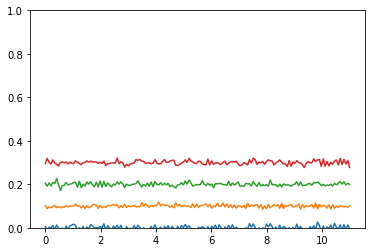

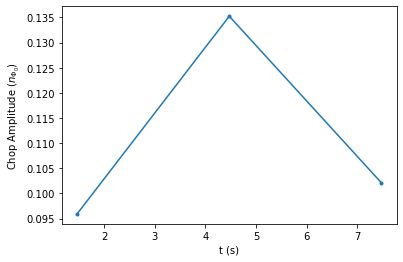

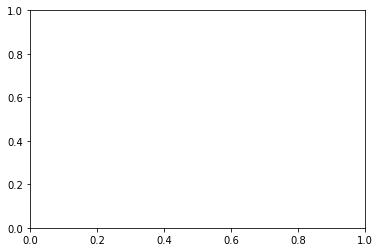

In [90]:
#this cell takes the pre-processed data above, performs flux ramp demod, and then attempts (albeit poorly) chop demod;
#the flux ramp demoded stream produced by this cell is what I passed to you for running through your own chop algorithm

t = test_ts_processed['fr t']
sig = test_ts_processed['fr data']
#channels = [201] #1, 7
#channels = np.linspace(0,133,num=134,dtype=int)
#channels = [203,204,205,206,207,208]
channels = [80,81,82,83]
chunks_demod = range(len(test_ts_processed['reset indices'])-2)
n_zeroed = 0
f_fr = 15 #Hz



full_demod_signal = np.array([])
full_demod_t = np.array([])

full_pol_amp_array = np.array([])
full_t_array = np.array([])
print("channels = ",channels)

for i in tqdm(range(30)):

    start_idx = find_nearest_idx(t,60*i)
    stop_idx = find_nearest_idx(t,60*(i+1))
    
    #print(start_idx,stop_idx)
    #print(t[start_idx:stop_idx])
    
    reduced_reset_indices = test_ts_processed['reset indices'][test_ts_processed['reset indices'] <= stop_idx]
    reduced_reset_indices = reduced_reset_indices[reduced_reset_indices >= start_idx]
    
    #print(reduced_reset_indices)
    
    #print(len(t[start_idx:stop_idx]))
    
    #reset_indices = 
    
    
    n_points_no_interp = (t[-1]-t[0])*f_fr
    idx_increase_no_interp = int(n_points_no_interp)
    #endpoint_idx = find_nearest_idx(t,t[test_ts_processed['start index']] + idx_increase_no_interp*(chunk+1) - n_zeroed)
            
    
    
    chunks_demod = range(len(reduced_reset_indices)-2)
    print(chunks_demod)

    
    t_array, phase_array = demodulate(t=t[start_idx:stop_idx],
                                      sig=sig[:,start_idx:stop_idx],
                                      channels=channels,
                                      chunks=chunks_demod,
                                      n_zeroed=n_zeroed,
                                      f_fr=f_fr,
                                      time_method='original',
                                      phase_units='n_Phi0',
                                      correct_accumulated_phase=True,
                                      use_sg_filter=False,
                                      sg_degree=2,
                                      plot_demod = True,
                                      intermediate_plotting_limits = [195, 205], #s #430 440 (155,157 plots) orig 195,205
                                      plot_chunking_process = False,
                                      plot_fft = False,
                                      plot_limited_fft = False,
                                      plot_fit = False,
                                      plot_vectors = False,
                                      plot_phase = False,
                                      verbose = False)
    
    full_demod_signal = np.append(full_demod_signal, phase_array)
    full_demod_t = np.append(full_demod_t, t_array)
    
    f_sample = 1/3 #Hz        
    try:
        t_sampled, amplitude_array = process_polarization_data(t_array=t_array, 
                                                               phase_array = phase_array, 
                                                               f_sample = f_sample, 
                                                               plot_polarization = False, 
                                                               intermediate_plotting_limits = [125, 135], #s
                                                               plot_input = False, 
                                                               plot_chunking_process = False, 
                                                               plot_fft = False, 
                                                               plot_fft_fit = False, 
                                                               plot_limited_fft = False, 
                                                               plot_limited_fft_fit = False, 
                                                               plot_vectors = False)
    
    except:
        pass
    
    full_t_array = np.append(full_t_array, t_sampled)
    full_pol_amp_array = np.append(full_pol_amp_array, amplitude_array)
    
    fig10, ax10 = plt.subplots(1)
    
    ax10.plot(full_t_array, full_pol_amp_array,'.-')
    ax10.set_xlabel('t (s)')
    ax10.set_ylabel('Chop Amplitude ($n_{\Phi_0}$)')

## Data output: run these cells to save data to files

### Save flux ramp stream

In [ ]:
#output_filename = './flux_ramp_example.csv' #enter your desired filename here; you can use standard Unix pathing


output_dataframe = pd.DataFrame({'t (s)':test_ts_processed['fr t'] , 'resonator position (arb.)': test_ts_processed['fr data']})
output_dataframe.to_csv(output_filename,sep=',')

### Save flux ramp demoded stream

In [66]:
#output_filename = './flux_ramp_demoded_example.csv' #enter your desired filename here; you can use standard Unix pathing
output_filename = './fts_20240611_95_chan203to204.csv' 

output_dataframe = pd.DataFrame({'t (s)':full_demod_t , 'phase (n_Phi0)': full_demod_signal})
output_dataframe.to_csv(output_filename,sep=',')

### Save chop demoded stream

In [ ]:
output_filename = './chop_demoded_example.csv' #enter your desired filename here; you can use standard Unix pathing

output_dataframe = pd.DataFrame({'t (s)':full_t_array , 'amplitude (arb.)': full_pol_amp_array})
output_dataframe.to_csv(output_filename,sep=',')

In [ ]:
#demod and stack channels

ts_file = 'ts_toneinit_fcenter_4250.0_20240611135725_t_20240611172020.hd5'  #203-210? 212-220, 222-230; 95 GHz
#ts_file = 'ts_toneinit_fcenter_4250.0_20240611135725_t_20240611171512.hd5'    # 10s of data, prep for 95 GHz scan (bias 9)
f_sawtooth=15

test_ts_processed = dm.full_demod_process(ts_file, 
                                          f_sawtooth, 
                                          method='fft', 
                                          n=0, 
                                          channels='all',
                                          correct_phase_jumps=True,
                                          start_channel=203,
                                          stop_channel=210,
                                          tone_init_path = '/home/matt/ali_drive_mnt/tone_initializations', 
                                          ts_path = '/home/matt/ali_drive_mnt/time_streams',
                                          display_mode = 'notebook')    

fig, ax = plt.subplots(1)

for i in range(len(test_ts_processed['demod t'])):
    ax.plot(test_ts_processed['demod t'], test_ts_processed['demod data'][i] - np.average(test_ts_processed['demod data'][i] + i*0.1))